In [1]:
import os
import re
import json
import requests
import pandas as pd
from bs4 import BeautifulSoup
from typing import Dict, List, Optional, Union, cast

# Plots, Graphs, & Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.dates import DateFormatter

# ------------- #
# Local Imports #
# ------------- #

## importing sys
import sys

## adding 00_helper_files to the system path as First Location to look
sys.path.insert(0, '/Users/qmcbt/codeup-data-science/00_helper_files')
## adding 03_projects Personal Work folder for current project to the system path as Second Location to look
sys.path.insert(1, '/Users/qmcbt/codeup-data-science/03_projects/Codeup-Mirzakhani-GitHub-Scrape-NLP-Project/justin_docs')
## adding 03_projects Root folder for current project to the system path as Third Location to look
sys.path.insert(2, '/Users/qmcbt/codeup-data-science/03_projects/Codeup-Mirzakhani-GitHub-Scrape-NLP-Project')

## env containing sensitive access credentials
import env
from env import github_token, github_username
from env import user, password, host
from env import get_db_url

## Import Helper Modules
import QMCBT_00_quicktips as qt
import QMCBT_01_acquire as acq
import QMCBT_02_prepare as prep
import QMCBT_03_explore as exp
import QMCBT_04_visualize as viz
import QMCBT_05_model as mod
import acquire as ac
import prepare as pr

# Seed 42
# Split 50/30/20

In [2]:
qt.imports()


    # ---------------- #
    # Common Libraries #
    # ---------------- #
      
    # Standard Imports
    import os
    import requests
    import numpy as np
    import pandas as pd

    # Working with Dates & Times
    from sklearn.model_selection import TimeSeriesSplit
    from datetime import timedelta, datetime

    # Working with Math & Stats
    import statsmodels.api as sm
    import scipy.stats as stats

    # to evaluate performance using rmse
    from sklearn.metrics import mean_squared_error
    from math import sqrt 

    # holt's linear trend model. 
    from statsmodels.tsa.api import Holt

    # Plots, Graphs, & Visualization
    import seaborn as sns
    import matplotlib.pyplot as plt
    from matplotlib.ticker import StrMethodFormatter
    from matplotlib.dates import DateFormatter

    # plotting defaults
    plt.rc('figure', figsize=(13, 7))
    plt.style.use('seaborn-whitegrid')
    plt.rc('font', size=16)

    

    # --------- #
    # Data Sets #
    # -----

# Acquire

In [3]:
df = pr.get_clean_df()

In [4]:
df

,original,first_clean,clean,lemmatized,language
0,"<p align=""center""><img src=""https://live.stati...",SpaceX REST API Open Source REST API for lau...,spacex rest api open source rest api launch ro...,spacex rest api open source rest api launch ro...,JavaScript
1,\nARCHIVED VERSION OF Space Engineers. This ve...,ARCHIVED VERSION OF Space Engineers. This vers...,archived version engineers version uptodate ve...,archived version engineer version uptodate ver...,C#
2,# Spaceship Generator\n\nA Blender script to p...,# Spaceship Generator A Blender script to pro...,spaceship generator blender script procedurall...,spaceship generator blender script procedurall...,Python
3,# Spacegray\n\nA set of custom UI themes for S...,# Spacegray A set of custom UI themes for Sub...,spacegray set custom ui themes sublime text hy...,spacegray set custom ui theme sublime text hyp...,JavaScript
4,# S P A C E\n\n![cover](resources/space-readme...,# S P A C E ![cover . You can read it here: ...,p c e cover read,p c e cover read,JavaScript
...,...,...,...,...,...
427,# Simple multi-dataset detection\nAn object de...,# Simple multi-dataset detection An object det...,simple multidataset detection object detector ...,simple multidataset detection object detector ...,Python
428,\n![Python package](https://github.com/WagnerG...,![Python package .,python package,python package,Python
429,# UnityScreenSpaceMetaballs\nScreenSpace Metab...,# UnityScreenSpaceMetaballs ScreenSpace Metaba...,unityscreenspacemetaballs screenspace metaball...,unityscreenspacemetaballs screenspace metaball...,C#
430,Caching for Analytic Computations\n-----------...,Caching for Analytic Computations ------------...,caching analytic computations humans repeat st...,caching analytic computation human repeat stuf...,Python


In [5]:
df.language.unique()

['JavaScript', 'C#', 'Python', 'Java']
Categories (4, object): ['C#', 'Java', 'JavaScript', 'Python']

In [6]:
train, validate, test = pr.split_data(df, explore=True)

In [7]:
train.shape[0]/df.shape[0], validate.shape[0]/df.shape[0], test.shape[0]/df.shape[0]

(0.5578703703703703, 0.24074074074074073, 0.2013888888888889)

In [12]:
def word_groups(df, target):
    # split languages into seperate DataFrames
    js_lang = df[df[target] == 'JavaScript']
    cs_lang = df[df[target] == 'C#']
    jv_lang = df[df[target] == 'Java']
    py_lang = df[df[target] == 'Python']
    
    # create word groups on lemmatized column 
    js_lem = (' '.join(js_lang[js_lang[target] == 'JavaScript']['lemmatized'])).split()
    cs_lem = (' '.join(cs_lang[cs_lang[target] == 'C#']['lemmatized'])).split()
    jv_lem = (' '.join(jv_lang[jv_lang[target] == 'Java']['lemmatized'])).split()
    py_lem = (' '.join(py_lang[py_lang[target] == 'Python']['lemmatized'])).split()
    all_lem = (' '.join(df['lemmatized'])).split()
    
    # create word groups on clean column
    js_clean = (' '.join(js_lang[js_lang[target] == 'JavaScript']['clean'])).split()
    cs_clean = (' '.join(cs_lang[cs_lang[target] == 'C#']['clean'])).split()
    jv_clean = (' '.join(jv_lang[jv_lang[target] == 'Java']['clean'])).split()
    py_clean = (' '.join(py_lang[py_lang[target] == 'Python']['clean'])).split()
    all_clean = (' '.join(df['clean'])).split()
    
    print('js_lang, cs_lang, jv_lang, py_lang, js_lem, cs_lem, jv_lem, py_lem, all_lem, js_clean, cs_clean, jv_clean, py_clean, all_clean')    
    return js_lang, cs_lang, jv_lang, py_lang, js_lem, cs_lem, jv_lem, py_lem, all_lem, js_clean, cs_clean, jv_clean, py_clean, all_clean

In [13]:
js_lang, cs_lang, jv_lang, py_lang, js_lem, cs_lem, jv_lem, py_lem, all_lem, js_clean, cs_clean, jv_clean, py_clean, all_clean = word_groups(train, 'language')

js_lang, cs_lang, jv_lang, py_lang, js_lem, cs_lem, jv_lem, py_lem, all_lem, js_clean, cs_clean, jv_clean, py_clean, all_clean


### Original code to build defined function
js_lang = df[df.language == 'JavaScript']
cs_lang = df[df.language == 'C#']
jv_lang = df[df.language == 'Java']
py_lang = df[df.language == 'Python']

### Original code to build defined function
js_lem = (' '.join(js_lang[js_lang.language == 'JavaScript']['lemmatized']))
cs_lem = (' '.join(cs_lang[cs_lang.language == 'C#']['lemmatized']))
jv_lem = (' '.join(jv_lang[jv_lang.language == 'Java']['lemmatized']))
py_lem = (' '.join(py_lang[py_lang.language == 'Python']['lemmatized']))

### Original code to build defined function
js_clean = (' '.join(js_lang[js_lang.language == 'JavaScript']['clean']))
cs_clean = (' '.join(cs_lang[cs_lang.language == 'C#']['clean']))
jv_clean = (' '.join(jv_lang[jv_lang.language == 'Java']['clean']))
py_clean = (' '.join(py_lang[py_lang.language == 'Python']['clean']))

In [14]:
js_lang 

,original,first_clean,clean,lemmatized,language
23,Photoshop Design Space [![Build Status](https:...,Photoshop Design Space [![Build Status file a...,photoshop design build status file root reposi...,photoshop design build status file root reposi...,JavaScript
61,# space-invaders\nA vanilla JavaScript game wi...,# space-invaders A vanilla JavaScript game wit...,spaceinvaders vanilla javascript game html css...,spaceinvaders vanilla javascript game html cs ...,JavaScript
169,Command Line Spaced Repetition\n==============...,Command Line Spaced Repetition ===============...,command line spaced repetition command line sp...,command line spaced repetition command line sp...,JavaScript
225,HTML5 Space Fighter\n===================\n\nAn...,HTML5 Space Fighter =================== An HT...,html fighter html game written using gamejs li...,html fighter html game written using gamejs li...,JavaScript
415,# SS-refraction-through-depth-peeling-in-three...,# SS-refraction-through-depth-peeling-in-three...,ssrefractionthroughdepthpeelinginthreejs scree...,ssrefractionthroughdepthpeelinginthreejs scree...,JavaScript
...,...,...,...,...,...
218,"<p align=""center"">\n<img src=""https://capsule-...",## 📑 Feature - [x] Music System ...,feature x music system autocomplete play plays...,feature x music system autocomplete play plays...,JavaScript
333,This repository is a collection of recent expe...,This repository is a collection of recent expe...,repository collection recent experiments worki...,repository collection recent experiment workin...,JavaScript
382,# Music Popcorn\nA dynamic visualization of th...,# Music Popcorn A dynamic visualization of the...,music popcorn dynamic visualization music genre,music popcorn dynamic visualization music genre,JavaScript
252,![](./public/space-invaders-hero.svg)\n\n# Rea...,![,,,JavaScript


In [15]:
cs_lang 

,original,first_clean,clean,lemmatized,language
344,# DesignSpace\n\nhttps://www.youtube.com/watch...,# DesignSpace DesignSpace is a prototype d...,designspace designspace prototype design tool ...,designspace designspace prototype design tool ...,C#
279,All credit to Damned Robotics goes to:\nPlugin...,All credit to Damned Robotics goes to: Plugin/...,credit damned robotics goes pluginlots stuff r...,credit damned robotics go pluginlots stuff rmn...,C#
178,# Stockalike Station Parts Expansion Redux\n\n...,# Stockalike Station Parts Expansion Redux A ...,stockalike station parts expansion redux mod p...,stockalike station part expansion redux mod pa...,C#
204,# TQVaultAE\n[![Steam](https://img.shields.io/...,"# TQVaultAE [![Steam ### TQVault - Brandon ""...",tqvaultae steam tqvault brandon bman wallace o...,tqvaultae steam tqvault brandon bman wallace o...,C#
113,# StochasticScreenSpaceReflection\n\n![SSSR](h...,# StochasticScreenSpaceReflection ![SSSR for...,stochasticscreenspacereflection sssr help,stochasticscreenspacereflection sssr help,C#
144,# ProjectPorcupine [![Build Status](https://tr...,# ProjectPorcupine [![Build Status or email: ...,projectporcupine build status email quillquill...,projectporcupine build status email quillquill...,C#
49,"<p align=""center"">\n <img src=""../master/Ex...",--- --- # Luna Multipla...,luna multiplayer mod lmp multiplayer mod kerba...,luna multiplayer mod lmp multiplayer mod kerba...,C#
66,# Space Monke\n\nA PC Gorilla Tag mod that mak...,# Space Monke A PC Gorilla Tag mod that makes...,monke pc gorilla tag mod makes jumps super hug...,monke pc gorilla tag mod make jump super huge ...,C#
76,Screen Space Multiple Scattering for Unity\n==...,Screen Space Multiple Scattering for Unity ===...,screen multiple scattering unity repurposes ke...,screen multiple scattering unity repurposes ke...,C#
216,KerbalAlarmClock\n================\nA manageme...,KerbalAlarmClock ================ A management...,kerbalalarmclock management utility plugin ker...,kerbalalarmclock management utility plugin ker...,C#


In [16]:
jv_lang 

,original,first_clean,clean,lemmatized,language
271,[![Build Status](https://travis-ci.org/guardia...,[![Build Status,build status,build status,Java
379,![Banner](https://divestos.org/images/featureG...,"![Banner - If you want a quick erase use ""Ran...",banner want quick erase use random want quick ...,banner want quick erase use random want quick ...,Java
306,# ExpandableLayout\n\nA expandable Layout to s...,# ExpandableLayout A expandable Layout to sav...,expandablelayout expandable layout save reduce...,expandablelayout expandable layout save reduce...,Java
315,"# JavaSpace\n\n<p align=""center"">\n <a href...",# JavaSpace A collection of all the Java pr...,javaspace collection java programs worked far ...,javaspace collection java program worked far i...,Java
209,# Spaceships\n\nThis is a demo of the [SpaceBa...,# Spaceships This is a demo of the [SpaceBase...,spaceships demo spacebase realtime spatial dat...,spaceship demo spacebase realtime spatial data...,Java
98,This repository contains messy code for practi...,This repository contains messy code for practi...,repository contains messy code practicing mika...,repository contains messy code practicing mika...,Java
24,"<h2 align=""center"">NOTICE</h2>\n\nThis project...",NOTICE This project is continued with updates...,notice project continued updates galacticraftl...,notice project continued update galacticraftle...,Java
94,,,,,Java
111,# SpaceBukkit - the awesome way!\nA powerful y...,# SpaceBukkit - the awesome way! A powerful ye...,spacebukkit awesome way powerful yet simple we...,spacebukkit awesome way powerful yet simple we...,Java
286,[![Build Status](https://travis-ci.org/guardia...,[![Build Status,build status,build status,Java


In [17]:
py_lang 

,original,first_clean,clean,lemmatized,language
190,# Learning to Adapt Structured Output Space fo...,# Learning to Adapt Structured Output Space fo...,learning adapt structured output semantic segm...,learning adapt structured output semantic segm...,Python
22,# PySpace\nGLSL Fractal Ray Marcher in Python\...,# PySpace GLSL Fractal Ray Marcher in Python ...,pyspace glsl fractal ray marcher python instal...,pyspace glsl fractal ray marcher python instal...,Python
32,# ETM\n\nThis is code that accompanies the pap...,# ETM This is code that accompanies the paper...,etm code accompanies paper titled topic modeli...,etm code accompanies paper titled topic modeli...,Python
393,TermTrack\n---------\n\nTrack orbiting objects...,TermTrack --------- Track orbiting objects (s...,termtrack track orbiting objects international...,termtrack track orbiting object international ...,Python
313,# Computer Science Fundamentals - Time and Spa...,# Computer Science Fundamentals - Time and Spa...,computer science fundamentals time complexity ...,computer science fundamental time complexity s...,Python
...,...,...,...,...,...
300,`BioSimSpace <http://biosimspace.org>`__\n====...,`BioSimSpace `__ =============================...,biosimspace image target abuild alt build stat...,biosimspace image target abuild alt build stat...,Python
272,![Cosmonium](textures/cosmonium-name.png)\n\n[...,![Cosmonium,cosmonium,cosmonium,Python
37,# Privacy Engineering Collaboration Space\nThe...,# Privacy Engineering Collaboration Space The ...,privacy engineering collaboration nist privacy...,privacy engineering collaboration nist privacy...,Python
183,=============\nopenwisp-ipam\n=============\n\...,============= openwisp-ipam ============= .. ...,openwispipam image target aopenwispipamcibuild...,openwispipam image target aopenwispipamcibuild...,Python


In [18]:
js_lem

['photoshop',
 'design',
 'build',
 'status',
 'file',
 'root',
 'repository',
 'licensing',
 'detail',
 'thirdparty',
 'code',
 'thirdparty',
 'code',
 'list',
 'thirdparty',
 'code',
 'used',
 'project',
 'available',
 'spaceinvaders',
 'vanilla',
 'javascript',
 'game',
 'html',
 'cs',
 'walkthrough',
 'updated',
 'please',
 'see',
 'newest',
 'version',
 'full',
 'walkthrough',
 'software',
 'provided',
 'without',
 'warranty',
 'kind',
 'express',
 'implied',
 'including',
 'limited',
 'warranty',
 'merchantability',
 'fitness',
 'particular',
 'purpose',
 'noninfringement',
 'event',
 'shall',
 'author',
 'copyright',
 'holder',
 'liable',
 'claim',
 'damage',
 'liability',
 'whether',
 'action',
 'contract',
 'tort',
 'otherwise',
 'arising',
 'connection',
 'software',
 'use',
 'dealing',
 'software',
 'command',
 'line',
 'spaced',
 'repetition',
 'command',
 'line',
 'spaced',
 'repetition',
 'program',
 'written',
 'javascript',
 'using',
 'nodejs',
 'spaced',
 'repetition',

In [19]:
cs_lem

['designspace',
 'designspace',
 'prototype',
 'design',
 'tool',
 'htc',
 'vive',
 'urban',
 'designer',
 'architect',
 'first',
 'developed',
 'aec',
 'hackathon',
 'london',
 'tool',
 'demonstrates',
 'could',
 'load',
 'position',
 'reference',
 'image',
 'work',
 'scale',
 'add',
 'simple',
 'block',
 'volume',
 'sketch',
 'directly',
 'model',
 'note',
 'current',
 'version',
 'still',
 'quite',
 'bug',
 'ui',
 'model',
 'interaction',
 'usage',
 'repo',
 'contains',
 'unityd',
 'project',
 'file',
 'open',
 'project',
 'launch',
 'unityd',
 'select',
 'open',
 'navigate',
 'project',
 'folder',
 'control',
 'grip',
 'button',
 'hold',
 'one',
 'pan',
 'entire',
 'scene',
 'hold',
 'two',
 'zoomrotate',
 'entire',
 'scene',
 'trigger',
 'button',
 'click',
 'button',
 'select',
 'object',
 'movescalerotate',
 'object',
 'credit',
 'aec',
 'hackathon',
 'team',
 'carlos',
 'de',
 'la',
 'barrera',
 'lorenzo',
 'greco',
 'thomas',
 'phillips',
 'thomas',
 'van',
 'bouwel',
 'model'

In [20]:
jv_lem

['build',
 'status',
 'banner',
 'want',
 'quick',
 'erase',
 'use',
 'random',
 'want',
 'quick',
 'secure',
 'erase',
 'use',
 'cmwcrng',
 'want',
 'cryptographically',
 'secure',
 'slow',
 'erase',
 'use',
 'securerandom',
 'known',
 'issue',
 'device',
 'without',
 'real',
 'external',
 'storage',
 'two',
 'shown',
 'internal',
 'file',
 'table',
 'secondary',
 'drive',
 'never',
 'really',
 'filled',
 'last',
 'mb',
 'erased',
 'limitation',
 'due',
 'flash',
 'drive',
 'work',
 'partition',
 'layout',
 'android',
 'device',
 'never',
 'possible',
 'fully',
 'fill',
 'drive',
 'planned',
 'update',
 'better',
 'gui',
 'add',
 'fast',
 'csprng',
 'data',
 'source',
 'root',
 'support',
 'filling',
 'cache',
 'system',
 'root',
 'support',
 'fstrim',
 'ing',
 'partition',
 'goal',
 'fast',
 'eat',
 'battery',
 'use',
 'minimal',
 'permission',
 'use',
 'library',
 'necessary',
 'credit',
 'inkhorn',
 'portuguese',
 'translation',
 'library',
 'uncommons',
 'math',
 'license',
 'apac

In [21]:
py_lem

['learning',
 'adapt',
 'structured',
 'output',
 'semantic',
 'segmentation',
 'pytorch',
 'implementation',
 'method',
 'adapting',
 'semantic',
 'segmentation',
 'synthetic',
 'dataset',
 'source',
 'domain',
 'real',
 'dataset',
 'target',
 'domain',
 'based',
 'implementation',
 'result',
 'ranked',
 'rd',
 'visda',
 'challenge',
 'upate',
 'training',
 'code',
 'pytorch',
 'update',
 'evaluation',
 'code',
 'pytorch',
 'update',
 'pretrained',
 'vgg',
 'model',
 'code',
 'released',
 'pyspace',
 'glsl',
 'fractal',
 'ray',
 'marcher',
 'python',
 'installation',
 'video',
 'overview',
 'example',
 'od',
 'demo',
 'etm',
 'code',
 'accompanies',
 'paper',
 'titled',
 'topic',
 'modeling',
 'embedding',
 'space',
 'adji',
 'b',
 'dieng',
 'francisco',
 'j',
 'r',
 'ruiz',
 'david',
 'blei',
 'arxiv',
 'link',
 'etm',
 'defines',
 'word',
 'topic',
 'embedding',
 'likelihood',
 'word',
 'etm',
 'categorical',
 'whose',
 'natural',
 'parameter',
 'given',
 'dot',
 'product',
 'word',

In [23]:
all_lem

['build',
 'status',
 'designspace',
 'designspace',
 'prototype',
 'design',
 'tool',
 'htc',
 'vive',
 'urban',
 'designer',
 'architect',
 'first',
 'developed',
 'aec',
 'hackathon',
 'london',
 'tool',
 'demonstrates',
 'could',
 'load',
 'position',
 'reference',
 'image',
 'work',
 'scale',
 'add',
 'simple',
 'block',
 'volume',
 'sketch',
 'directly',
 'model',
 'note',
 'current',
 'version',
 'still',
 'quite',
 'bug',
 'ui',
 'model',
 'interaction',
 'usage',
 'repo',
 'contains',
 'unityd',
 'project',
 'file',
 'open',
 'project',
 'launch',
 'unityd',
 'select',
 'open',
 'navigate',
 'project',
 'folder',
 'control',
 'grip',
 'button',
 'hold',
 'one',
 'pan',
 'entire',
 'scene',
 'hold',
 'two',
 'zoomrotate',
 'entire',
 'scene',
 'trigger',
 'button',
 'click',
 'button',
 'select',
 'object',
 'movescalerotate',
 'object',
 'credit',
 'aec',
 'hackathon',
 'team',
 'carlos',
 'de',
 'la',
 'barrera',
 'lorenzo',
 'greco',
 'thomas',
 'phillips',
 'thomas',
 'van'

In [24]:
js_clean

['photoshop',
 'design',
 'build',
 'status',
 'file',
 'root',
 'repository',
 'licensing',
 'details',
 'thirdparty',
 'code',
 'thirdparty',
 'code',
 'list',
 'thirdparty',
 'code',
 'used',
 'project',
 'available',
 'spaceinvaders',
 'vanilla',
 'javascript',
 'game',
 'html',
 'css',
 'walkthrough',
 'updated',
 'please',
 'see',
 'newest',
 'version',
 'full',
 'walkthrough',
 'software',
 'provided',
 'without',
 'warranty',
 'kind',
 'express',
 'implied',
 'including',
 'limited',
 'warranties',
 'merchantability',
 'fitness',
 'particular',
 'purpose',
 'noninfringement',
 'event',
 'shall',
 'authors',
 'copyright',
 'holders',
 'liable',
 'claim',
 'damages',
 'liability',
 'whether',
 'action',
 'contract',
 'tort',
 'otherwise',
 'arising',
 'connection',
 'software',
 'use',
 'dealings',
 'software',
 'command',
 'line',
 'spaced',
 'repetition',
 'command',
 'line',
 'spaced',
 'repetition',
 'program',
 'written',
 'javascript',
 'using',
 'nodejs',
 'spaced',
 'repe

In [25]:
cs_clean 

['designspace',
 'designspace',
 'prototype',
 'design',
 'tool',
 'htc',
 'vive',
 'urban',
 'designers',
 'architects',
 'first',
 'developed',
 'aec',
 'hackathon',
 'london',
 'tool',
 'demonstrates',
 'could',
 'load',
 'position',
 'reference',
 'images',
 'work',
 'scale',
 'add',
 'simple',
 'block',
 'volumes',
 'sketch',
 'directly',
 'model',
 'note',
 'current',
 'version',
 'still',
 'quite',
 'bugs',
 'ui',
 'model',
 'interaction',
 'usage',
 'repo',
 'contains',
 'unityd',
 'project',
 'files',
 'open',
 'project',
 'launch',
 'unityd',
 'select',
 'open',
 'navigate',
 'project',
 'folder',
 'controls',
 'grip',
 'buttons',
 'hold',
 'one',
 'pan',
 'entire',
 'scene',
 'hold',
 'two',
 'zoomrotate',
 'entire',
 'scene',
 'trigger',
 'buttons',
 'click',
 'buttons',
 'select',
 'objects',
 'movescalerotate',
 'objects',
 'credits',
 'aec',
 'hackathon',
 'team',
 'carlos',
 'de',
 'la',
 'barrera',
 'lorenzo',
 'greco',
 'thomas',
 'phillips',
 'thomas',
 'van',
 'bouw

In [26]:
jv_clean

['build',
 'status',
 'banner',
 'want',
 'quick',
 'erase',
 'use',
 'random',
 'want',
 'quick',
 'secure',
 'erase',
 'use',
 'cmwcrng',
 'want',
 'cryptographically',
 'secure',
 'slow',
 'erase',
 'use',
 'securerandom',
 'known',
 'issues',
 'devices',
 'without',
 'real',
 'external',
 'storage',
 'two',
 'shown',
 'internal',
 'file',
 'table',
 'secondary',
 'drive',
 'never',
 'really',
 'filled',
 'last',
 'mb',
 'erased',
 'limitations',
 'due',
 'flash',
 'drives',
 'work',
 'partition',
 'layout',
 'android',
 'devices',
 'never',
 'possible',
 'fully',
 'fill',
 'drive',
 'planned',
 'updates',
 'better',
 'gui',
 'add',
 'fast',
 'csprng',
 'data',
 'source',
 'root',
 'support',
 'filling',
 'cache',
 'system',
 'root',
 'support',
 'fstrim',
 'ing',
 'partitions',
 'goals',
 'fast',
 'eat',
 'batteries',
 'use',
 'minimal',
 'permissions',
 'use',
 'libraries',
 'necessary',
 'credits',
 'inkhorn',
 'portuguese',
 'translations',
 'library',
 'uncommons',
 'maths',
 '

In [27]:
py_clean

['learning',
 'adapt',
 'structured',
 'output',
 'semantic',
 'segmentation',
 'pytorch',
 'implementation',
 'method',
 'adapting',
 'semantic',
 'segmentation',
 'synthetic',
 'dataset',
 'source',
 'domain',
 'real',
 'dataset',
 'target',
 'domain',
 'based',
 'implementation',
 'result',
 'ranked',
 'rd',
 'visda',
 'challenge',
 'upate',
 'training',
 'code',
 'pytorch',
 'update',
 'evaluation',
 'code',
 'pytorch',
 'update',
 'pretrained',
 'vgg',
 'model',
 'code',
 'released',
 'pyspace',
 'glsl',
 'fractal',
 'ray',
 'marcher',
 'python',
 'installation',
 'videos',
 'overview',
 'examples',
 'ods',
 'demo',
 'etm',
 'code',
 'accompanies',
 'paper',
 'titled',
 'topic',
 'modeling',
 'embedding',
 'spaces',
 'adji',
 'b',
 'dieng',
 'francisco',
 'j',
 'r',
 'ruiz',
 'david',
 'blei',
 'arxiv',
 'link',
 'etm',
 'defines',
 'words',
 'topics',
 'embedding',
 'likelihood',
 'word',
 'etm',
 'categorical',
 'whose',
 'natural',
 'parameter',
 'given',
 'dot',
 'product',
 '

In [28]:
all_clean

['build',
 'status',
 'designspace',
 'designspace',
 'prototype',
 'design',
 'tool',
 'htc',
 'vive',
 'urban',
 'designers',
 'architects',
 'first',
 'developed',
 'aec',
 'hackathon',
 'london',
 'tool',
 'demonstrates',
 'could',
 'load',
 'position',
 'reference',
 'images',
 'work',
 'scale',
 'add',
 'simple',
 'block',
 'volumes',
 'sketch',
 'directly',
 'model',
 'note',
 'current',
 'version',
 'still',
 'quite',
 'bugs',
 'ui',
 'model',
 'interaction',
 'usage',
 'repo',
 'contains',
 'unityd',
 'project',
 'files',
 'open',
 'project',
 'launch',
 'unityd',
 'select',
 'open',
 'navigate',
 'project',
 'folder',
 'controls',
 'grip',
 'buttons',
 'hold',
 'one',
 'pan',
 'entire',
 'scene',
 'hold',
 'two',
 'zoomrotate',
 'entire',
 'scene',
 'trigger',
 'buttons',
 'click',
 'buttons',
 'select',
 'objects',
 'movescalerotate',
 'objects',
 'credits',
 'aec',
 'hackathon',
 'team',
 'carlos',
 'de',
 'la',
 'barrera',
 'lorenzo',
 'greco',
 'thomas',
 'phillips',
 'th

# RegEx

## Metacharacters

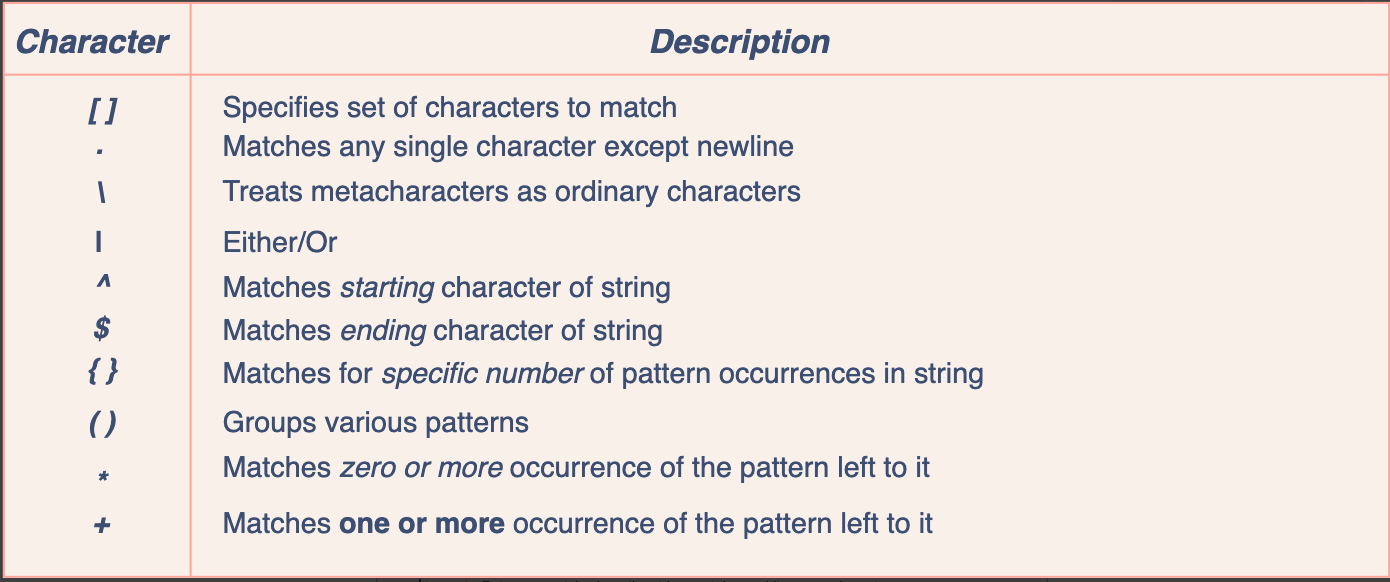

## Special Sequences

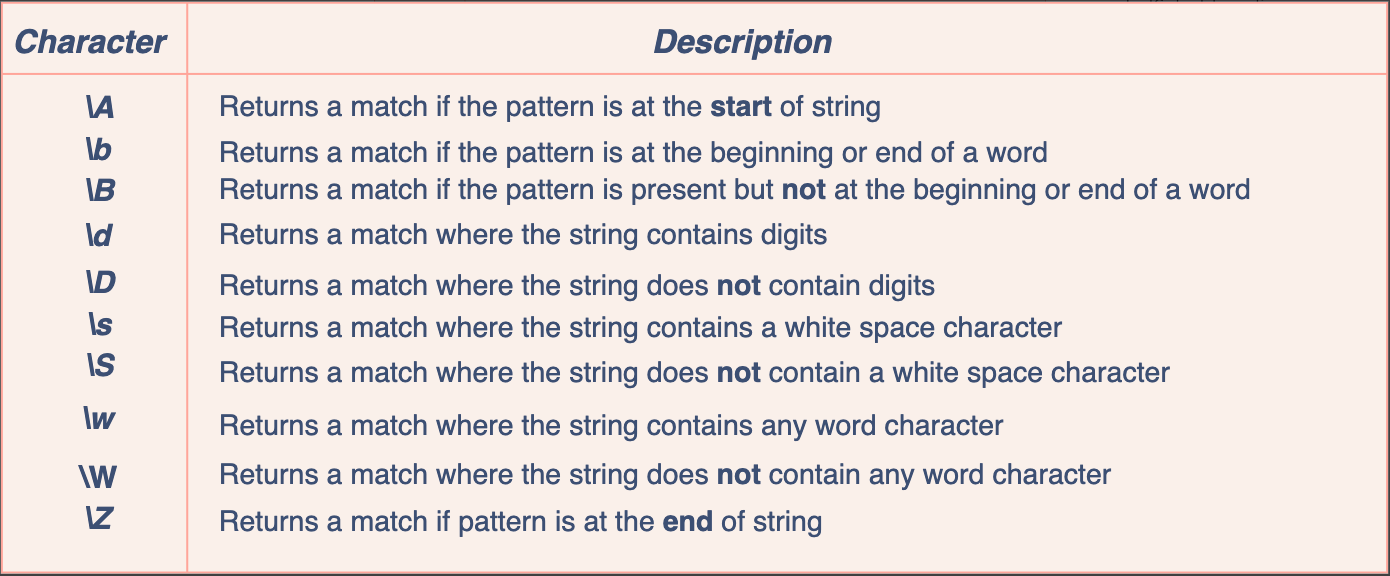

# RegEx functions
The re module provides users a variety of functions to search for a pattern in a particular string. Below are some of the most frequently used functions in detail:

### 1. re.findall()
The re.findall() function returns a list of strings containing all matches of the specified pattern.
The function takes as input the following:
* a character pattern
* the string from which to search  
```
string = "at what time?"
match = re.findall('at',string)
```
### 2. re.search()
The re.search() function returns a match object in case a match is found.  
The function takes as input the following:
* a character pattern
* the string from which to search  
```
string = "at what time?"
match = re.search('at',string)
```
### 3. re.split()
The re.split() function splits the string at every occurrence of the sub-string and returns a list of strings which have been split.  
The function takes as input the following:
* a character pattern
* the string from which to search  
```
string = "at what time?"
match = re.split('a',string)
```
### 4. re.sub()
The re.sub() function is used to replace occurrences of a particular sub-string with another sub-string.
This function takes as input the following:
* The sub-string to replace
* The sub-string to replace with
* The actual string
```
string = "at what time?"
match = re.sub("\s","!!!",string)
```

# Clean using RegEx

## Remove Links Replace with Displayed Text

# <center>```\[```    ```(.+)```    ```\]```</center>

|01 |02 |03 |04 |05 |06 |
|:-:|:-:|:-:|:-:|:-:|:-:|
|literal_Bracket|open_Group1|anything|1_or_more_times|close_Group1|literal_Bracket|
|\\ [           |(          |.       |+              |)           |\\]            |

# <center>```\(```    ```.```    ```+```    ```\)```</center>
|07 |08 |09 |10 |
|:-:|:-:|:-:|:-:|
|literal_Parenthesis|anything|1_or_more_times|literal_Parenthesis|
|\(                 |.       |+              |\)                 |


In [29]:
# Test text
text = """
        <html>Pull this data out</html><html><body><h1 align="center">
        <a href="https://spacevim.org/cn/">
        <img alt="SpaceVim" src="https://spacevim.org/logo.png" width="600"/>
        </a>
        </h1>
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [This is a link that needs to be Deleted!](https://www.This_is_a_link_that_needs_to_be_Deleted.com)
        [@kenney](http://opengameart.org/users/kenney)
        """

In [30]:
# Remove Links in parenthesis () following text in brackets [] then Replace Displayed Text from group 1 in brackets
stripped_links = re.sub(r"\[(.+)\]\(.+\)", r"\1", text)

In [31]:
# Take a look
stripped_links

'\n        <html>Pull this data out</html><html><body><h1 align="center">\n        <a href="https://spacevim.org/cn/">\n        <img alt="SpaceVim" src="https://spacevim.org/logo.png" width="600"/>\n        </a>\n        </h1>\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        This is a link that needs to be Deleted!\n        @kenney\n        '

In [32]:
# Remove line breaks \n
stripped_line_break = stripped_links.replace("\n", '')
stripped_line_break

'        <html>Pull this data out</html><html><body><h1 align="center">        <a href="https://spacevim.org/cn/">        <img alt="SpaceVim" src="https://spacevim.org/logo.png" width="600"/>        </a>        </h1>        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        This is a link that needs to be Deleted!        @kenney        '

## Remove HTML tags

In [33]:
# Import Module
from bs4 import BeautifulSoup
import requests
 
# Website URL
URL = 'https://www.geeksforgeeks.org/data-structures/'
 
# Page content from Website URL
page = requests.get(URL)
 
# Function to remove tags
def remove_tags(html):
 
    # parse html content
    soup = BeautifulSoup(html, "html.parser")
 
    for data in soup(['style', 'script']):
        # Remove tags
        data.decompose()
 
    # return data by retrieving the tag content
    return ' '.join(soup.stripped_strings)
 
 
# Print the extracted data
#print(remove_tags(page.content))

# EXPLORE

### list Variable
js_lem, cs_lem, jv_lem, py_lem,  
js_clean, cs_clean, jv_clean, py_clean

In [34]:
# word count
len(js_lem), len(cs_lem), len(jv_lem), len(py_lem)

(5244, 7452, 1412, 6073)

In [35]:
# word count
len(js_clean), len(cs_clean), len(jv_clean), len(py_clean)

(5244, 7452, 1412, 6073)

In [61]:
train.language.value_counts(normalize=True)

JavaScript    0.352697
Python        0.319502
C#            0.215768
Java          0.112033
Name: language, dtype: float64

In [62]:
# JavaScript average Readme word count
train.language.value_counts(normalize=True)[0]*len(js_clean)

1849.5435684647305

In [63]:
# Python average Readme word count
train.language.value_counts(normalize=True)[1]*len(py_clean)

1940.3360995850621

In [64]:
# C# average Readme word count
train.language.value_counts(normalize=True)[2]*len(cs_clean)

1607.9004149377595

In [65]:
# Java average Readme word count
train.language.value_counts(normalize=True)[3]*len(jv_clean)

158.1908713692946

In [38]:
# Create frequency Series for lem
js_lem_freq = pd.Series(js_lem).value_counts()
cs_lem_freq = pd.Series(cs_lem).value_counts()
jv_lem_freq = pd.Series(jv_lem).value_counts()
py_lem_freq = pd.Series(py_lem).value_counts()
all_lem_freq = pd.Series(all_lem).value_counts()

# Create frequency Series for clean
js_clean_freq = pd.Series(js_clean).value_counts()
cs_clean_freq = pd.Series(cs_clean).value_counts()
jv_clean_freq = pd.Series(jv_clean).value_counts()
py_clean_freq = pd.Series(py_clean).value_counts()
all_clean_freq = pd.Series(all_clean).value_counts()

In [39]:
lem_word_counts = pd.concat([js_lem_freq, cs_lem_freq, jv_lem_freq, py_lem_freq, all_lem_freq], 
                            axis=1).fillna(0).astype(int)
lem_word_counts.columns = ['JavaScript','C#','Java', 'Python', 'All']
lem_word_counts.head()

,JavaScript,C#,Java,Python,All
fixed,82,72,1,2,157
x,50,3,0,4,57
use,41,38,16,27,122
software,40,37,3,16,96
v,33,86,3,1,123


In [40]:
clean_word_counts = pd.concat([js_clean_freq, cs_clean_freq, jv_clean_freq, py_clean_freq, all_clean_freq], 
                            axis=1).fillna(0).astype(int)
clean_word_counts.columns = ['JavaScript','C#','Java', 'Python', 'All']
clean_word_counts.head()

,JavaScript,C#,Java,Python,All
fixed,82,72,1,2,157
x,50,3,0,4,57
use,41,38,16,27,122
software,40,37,3,16,96
v,33,81,2,1,117


In [41]:
# sort by 'all'
lem_word_counts.sort_values('All', ascending=False)

,JavaScript,C#,Java,Python,All
&#9;,7,528,0,56,591
fixed,82,72,1,2,157
part,8,117,0,3,128
v,33,86,3,1,123
use,41,38,16,27,122
...,...,...,...,...,...
mileage,0,1,0,0,1
sharing,0,1,0,0,1
present,0,1,0,0,1
creator,0,1,0,0,1


In [42]:
# sort by 'ham' and 'spam' columns
lem_word_counts.sort_values(['JavaScript','C#','Java', 'Python', 'All'], ascending=False)

,JavaScript,C#,Java,Python,All
fixed,82,72,1,2,157
x,50,3,0,4,57
use,41,38,16,27,122
software,40,37,3,16,96
v,33,86,3,1,123
...,...,...,...,...,...
duelsavedh,0,0,0,1,1
savedh,0,0,0,1,1
gym,0,0,0,1,1
openai,0,0,0,1,1


<AxesSubplot:>

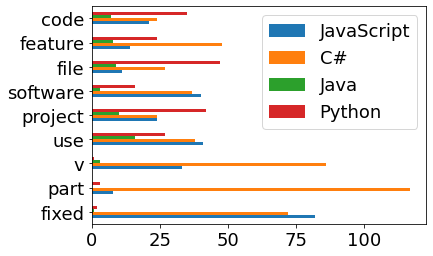

In [67]:
plt.rc('font', size=18)
lem_word_counts.sort_values('All', ascending=False
                           )[['JavaScript','C#','Java', 'Python']][1:10].plot.barh()

In [69]:
lem_word_counts.sort_values('All', ascending=False)\
 .head(10)\
 .apply(lambda row: row/row['All'], axis = 1)

,JavaScript,C#,Java,Python,All
&#9;,0.011844,0.893401,0.000000,0.094755,1.0
fixed,0.522293,0.458599,0.006369,0.012739,1.0
part,0.062500,0.914062,0.000000,0.023438,1.0
v,0.268293,0.699187,0.024390,0.008130,1.0
use,0.336066,0.311475,0.131148,0.221311,1.0
project,0.240000,0.240000,0.100000,0.420000,1.0
software,0.416667,0.385417,0.031250,0.166667,1.0
file,0.117021,0.287234,0.095745,0.500000,1.0
feature,0.148936,0.510638,0.085106,0.255319,1.0
code,0.241379,0.275862,0.080460,0.402299,1.0


<Figure size 1152x648 with 0 Axes>

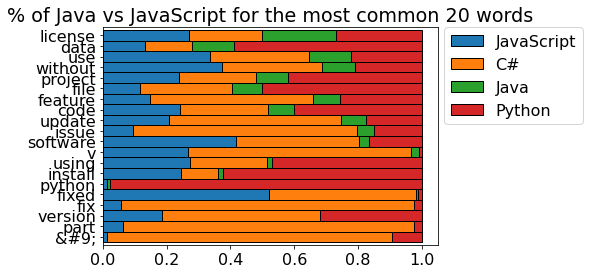

In [74]:
plt.figure(figsize=(16, 9))
plt.rc('font', size=16)

(lem_word_counts.sort_values('All', ascending=False)
 .head(20)
 .apply(lambda row: row/row['All'], axis = 1)
 .drop(columns = 'All')
 .sort_values(by = 'Java')
 .plot.barh(stacked = True, width = 1, ec = 'k', legend=False)
)
plt.title('% of Java vs JavaScript for the most common 20 words')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)